In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import csv
import sys
sys.path.append(r"C:\Users\vl385\Documents\casadi-windows-py37-v3.5.1")
from casadi import *
import GPy
import pickle
import numpy.linalg as LA
from numpy import genfromtxt
import time
from numba import jit


In [ ]:
@jit(nopython=True)
def three_dot(A, B, C):
    return np.dot(A, np.dot(B, C))

@jit(nopython=True)
def four_dot(A, B, C, D):
    return np.dot(A, three_dot(B, C, D))

@jit(nopython=True)
def five_dot(A, B, C, D, E):
    return np.dot(A, four_dot(B, C, D, E))

@jit(nopython=True)
def se_kernel(x, y, v, ls_inv):
    return v**2*np.exp(-0.5*three_dot((x-y).transpose(), ls_inv, (x-y)))

@jit(nopython=True)
def se_kernel_01(x, y, v, ls_inv):
    a = se_kernel(x, y, v, ls_inv)
    b = np.dot(ls_inv, (x-y).transpose())
    return a*b

@jit(nopython=True)
def se_kernel_10(x, y, v, ls_inv):
    a = se_kernel(x, y, v, ls_inv)
    b = -np.dot(ls_inv, (x-y))
    return a*b

@jit(nopython=True)
def se_kernel_11(x, y, v, ls_inv):
    l = len(x)
    a = se_kernel(x, y, v, ls_inv)
    b = np.dot(se_kernel_10(x, y, v, ls_inv).reshape(-1, 1), (x-y).reshape(1,-1))
    return a + b

In [ ]:
@jit(nopython=True)
def Sigma_inverse(X, Y, Z, v, ls_inv, v_noise, N, N_ind):
    # Pre-compute (K_N + sigma^2*I)^-1        
    K_NZ = np.empty((N, N_ind)) 
    K_ZZ = np.empty((N_ind, N_ind))  
    K_NN = np.empty((N, N))
    for i in range(N):
        for j in range(N_ind):
            K_NZ[i,j] = se_kernel(X[i,:], Z[j,:], v, ls_inv)
    for i in range(N_ind):
        for j in range(N_ind):
            K_ZZ[i,j] = se_kernel(Z[i,:], Z[j,:], v, ls_inv)
    for i in range(N):
        for j in range(N):
            K_NN[i,j] = se_kernel(X[i,:], X[j,:], v, ls_inv)

    K_ZN = K_NZ.transpose()
    Q_NN = three_dot(K_NZ, LA.inv(K_ZZ), K_ZN)
    LAMBDA = np.diag(np.diag(K_NN - Q_NN + v_noise**2*np.eye(N)))
    Sigma_inv = LA.inv(Q_NN + LAMBDA)
    alpha = four_dot(LA.inv(K_ZZ), K_ZN, Sigma_inv, Y) 
    beta = five_dot(LA.inv(K_ZZ), K_ZN, Sigma_inv, \
                              K_ZN.transpose(), LA.inv(K_ZZ).transpose())
#     return Sigma_inv, alpha, beta

In [ ]:
@jit(nopython=True)
def predict(p, alpha, beta, v, ls_inv, v_noise, Z, N_ind):
    K_star_Z = np.empty(N_ind)
    for i in range(N_ind):
        K_star_Z[i] = se_kernel(p, Z[i, :], v, ls_inv)
    mean = np.dot(K_star_Z, alpha)
    return mean

In [ ]:
@jit(nopython=True)
def linearize(p, alpha, beta, v, ls_inv, v_noise, Z, N_ind, n):
    K_star_Z = np.empty(N_ind)
    K10_star_Z = np.empty((n, N_ind))
    for i in range(N_ind):
        K_star_Z[i] = se_kernel(p, Z[i, :], v, ls_inv,)
        K10_star_Z[:, i] = se_kernel_10(p, Z[i, :], v, ls_inv)
    A = np.vstack((K_star_Z.reshape(1,-1), K10_star_Z))
    mx = np.dot(A, alpha)
    return mx

In [5]:
class linsparse_GP:
    def __init__(self, model):
        # Initialize by GPy model or by dictionary containing all information
        if type(model) == dict:
            self.rbf_variance = model["rbf_variance"]
            self.rbf_lengthscale = model["rbf_lengthscale"]
            self.noise_variance = model["noise_variance"]
            self.X = model["X_train"]
            self.Y = model["Y_train"]
            self.Z = model["X_ind"]
            
        self.N = len(self.Y)
        self.N_ind = len(self.Z)
        self.n = np.shape(self.X)[1]
        self.lambda_inv = np.diag(1/self.rbf_lengthscale**2)
        self.Sigma_inverse()
        
    def Sigma_inverse(self):
        # Pre-compute (K_N + sigma^2*I)^-1        
        self.K_NZ = np.empty((self.N, self.N_ind)) 
        self.K_ZZ = np.empty((self.N_ind, self.N_ind))  
        K_NN = np.empty((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N_ind):
                self.K_NZ[i,j] = self.se_kernel(self.X[i,:], self.Z[j,:])
        for i in range(self.N_ind):
            for j in range(self.N_ind):
                self.K_ZZ[i,j] = self.se_kernel(self.Z[i,:], self.Z[j,:])
        for i in range(self.N):
            for j in range(self.N):
                K_NN[i,j] = self.se_kernel(self.X[i,:], self.X[j,:])
           
        self.K_ZN = self.K_NZ.transpose()
        Q_NN = LA.multi_dot([self.K_NZ, LA.inv(self.K_ZZ), self.K_ZN])
        LAMBDA = np.diag(np.diag(K_NN - Q_NN + self.noise_variance**2*np.eye(self.N)))
        self.Sigma_inv = LA.inv(Q_NN + LAMBDA)
        self.alpha = LA.multi_dot([LA.inv(self.K_ZZ), self.K_ZN, self.Sigma_inv, self.Y]) 
        self.beta = LA.multi_dot([LA.inv(self.K_ZZ), self.K_ZN, self.Sigma_inv, \
                                  self.K_ZN.transpose(), LA.inv(self.K_ZZ).transpose()]) 
    
    def se_kernel(self, x, y):
        if type(x) == np.ndarray and type(y) == np.ndarray:
            return self.rbf_variance**2*exp(-0.5*LA.multi_dot([(x-y).transpose(), self.lambda_inv, (x-y)]))


In [6]:
# Load gp model from file, using linGP class
m_dict = pickle.load(open("sparse_dx.pkl", "rb"))
gp_dx = linsparse_GP(m_dict)

m_dict = pickle.load(open("sparse_dy.pkl", "rb"))
gp_dy = linsparse_GP(m_dict)

m_dict = pickle.load(open("sparse_dth.pkl", "rb"))
gp_dth = linsparse_GP(m_dict)

In [35]:
from numba_fcn import *

In [36]:
# Warm up
predict(gp_dx.X[0,:], gp_dx.alpha, gp_dx.beta, gp_dx.rbf_variance, gp_dx.lambda_inv, gp_dx.noise_variance, gp_dx.Z, gp_dx.N_ind)
linearize(gp_dx.X[0,:], gp_dx.alpha, gp_dx.beta, gp_dx.rbf_variance, gp_dx.lambda_inv, gp_dx.noise_variance, gp_dx.Z, gp_dx.N_ind, gp_dx.n)


array([[ 0.29450164],
       [ 0.25689588],
       [-0.00037243],
       [ 0.1426474 ],
       [-0.12452423]])

## linGP-SCP

In [37]:
def vertical_reshape(v):
    n_row, n_col = np.shape(v)
    output = v[:,0].reshape(-1) 
    for i in range(1, n_col):
        output = np.hstack([output, v[:,i].reshape(-1)])
    return output

In [52]:
class linGP_car:
    T = 0.2; H = 10
    lf = 0.16; lr = 0.17

    v_min = 0; v_max = 2
    de_min = -0.4; de_max = 0.4
    Q = 0; R = 0
    
    J = 0; # Objective function
    g = [] # Constraints
    lbg = []; ubg = []
    lbx = []; ubx = [] 
    thres = 0.001
    
    
    def __init__(self, x0, GP_dx, GP_dy, GP_dth):
        self.st = x0
        self.input = np.array([0.0, 0.0])
        self.gp_dx = GP_dx
        self.gp_dy = GP_dy
        self.gp_dth = GP_dth
        self.ramp_v_min = -5*self.T; self.ramp_v_max = 5*self.T; 
        self.ramp_de_min = -np.pi*self.T; self.ramp_de_max = np.pi*self.T
        
        self.v_nom = np.zeros(self.H); self.de_nom = np.zeros(self.H)
        self.x_nom = np.zeros(self.H+1); self.y_nom = np.zeros(self.H+1); self.th_nom = np.zeros(self.H+1) 
        self.m_dx = np.zeros((self.H,4)); self.m_dy = np.zeros((self.H,4)); self.m_dth = np.zeros((self.H,3))
        
        self.v_H = np.zeros(self.H); self.de_H = np.zeros(self.H)
                        
    def set_params(self, Q, R, ref):
        self.Q = Q
        self.R = R
        self.ref = ref
    
    def objective(self, x, y, v, de, x_r, y_r):
        obj = 0
        for k in range (self.H):
            obj += self.Q[0]*(x[k+1] - x_r[k])**2 + self.Q[1]*(y[k+1] - y_r[k])**2 \
                + self.R[0]*v[k]**2 + self.R[1]*de[k]**2
        return obj  
        
    def update_linGP(self, v, de):
        # Update linGP model (m_hat for mean) for dth and dx, dy
        x = np.zeros(self.H+1); y = np.zeros(self.H+1); th = np.zeros(self.H+1) 
        x[0] = self.st[0]; y[0] = self.st[1]; th[0] = self.st[2]

        for k in range(self.H):
            xk = np.array([v[k], de[k]]) 
            m_dth = linearize(xk, gp_dth.alpha, gp_dth.beta, gp_dth.rbf_variance, gp_dth.lambda_inv, gp_dth.noise_variance, \
                gp_dth.Z, gp_dth.N_ind, gp_dth.n)
            self.m_dth[k] = m_dth.reshape((-1,))
            th[k+1] = th[k] + m_dth[0]
        
        for k in range(self.H):
            xk = np.array([np.cos(th[k]), np.sin(th[k]), v[k], de[k]]) 
            m_dx = linearize(xk, gp_dx.alpha, gp_dx.beta, gp_dx.rbf_variance, gp_dx.lambda_inv, gp_dx.noise_variance, \
                 gp_dx.Z, gp_dx.N_ind, gp_dx.n)
            m_dy = linearize(xk, gp_dy.alpha, gp_dy.beta, gp_dy.rbf_variance, gp_dy.lambda_inv, gp_dy.noise_variance, \
                 gp_dy.Z, gp_dy.N_ind, gp_dy.n)            
            x[k+1] = x[k] + m_dx[0]
            y[k+1] = y[k] + m_dy[0]
            M = np.array([np.hstack([1, np.zeros(4)]), np.hstack([0, -xk[1], xk[0], np.zeros(2)]), 
              np.hstack([np.zeros(3), 1, 0]), np.hstack([np.zeros(4), 1])])
            self.m_dx[k] = np.dot(M, m_dx.reshape((-1,)))
            self.m_dy[k] = np.dot(M, m_dy.reshape((-1,))) 
            
        self.v_nom = v; self.de_nom = de
        self.x_nom = x; self.y_nom = y; self.th_nom = th    
    
    def simulate_linGP(self, dv, dde):
        dx = np.zeros(self.H); dy = np.zeros(self.H); dth = np.zeros(self.H)
        x = np.zeros(self.H+1); y = np.zeros(self.H+1); th = np.zeros(self.H+1) 
        x[0] = self.st[0]; y[0] = self.st[1]; th[0] = self.st[2]

        for k in range(self.H):
            dth[k] = self.m_dth[k,0] + self.m_dth[k,1]*dv[k] + self.m_dth[k,2]*dde[k]
            th[k+1] = th[k] + dth[k]
        
        for k in range(self.H):
            dx[k] = self.m_dx[k,0] + self.m_dx[k,1]*(th[k] - self.th_nom[k]) \
                    + self.m_dx[k,2]*dv[k] + self.m_dx[k,3]*dde[k]
            dy[k] = self.m_dy[k,0] + self.m_dy[k,1]*(th[k] - self.th_nom[k]) \
                    + self.m_dy[k,2]*dv[k] + self.m_dy[k,3]*dde[k]
            x[k+1] = x[k] + dx[k]
            y[k+1] = y[k] + dy[k]
        
        return x, y, th
            
    def simulate_GP(self, v, de):
        x = np.zeros(self.H+1); y = np.zeros(self.H+1); th = np.zeros(self.H+1) 
        x[0] = self.st[0]; y[0] = self.st[1]; th[0] = self.st[2]
        for k in range(self.H):
            xk = np.array([v[k], de[k]]) 
            th[k+1] = th[k] + predict(xk, gp_dth.alpha, gp_dth.beta, gp_dth.rbf_variance, gp_dth.lambda_inv, gp_dth.noise_variance, \
                  gp_dth.Z, gp_dth.N_ind )
        
        for k in range(self.H):
            xk = np.array([np.cos(th[k]), np.sin(th[k]), v[k], de[k]]) 
            x[k+1] = x[k] + predict(xk, gp_dx.alpha, gp_dx.beta, gp_dx.rbf_variance, gp_dx.lambda_inv, gp_dx.noise_variance, \
                    gp_dx.Z, gp_dx.N_ind)
            y[k+1] = y[k] + predict(xk, gp_dy.alpha, gp_dy.beta, gp_dy.rbf_variance, gp_dy.lambda_inv, gp_dy.noise_variance, \
                    gp_dy.Z, gp_dy.N_ind)
            
        return x, y, th

    def SCP_linGP(self, i, maxiters = 100, rho_min = 0.0, rho_max = inf, \
                  r0 = 0.0, r1 = 0.1, r2 = 0.2, b_fail = 0.5, b_succ = 2.0):
        self.rho = 0.5
        self.update_linGP(np.hstack([self.v_H[1:], self.v_H[0]]), np.hstack([self.de_H[1:], self.de_H[0]]))
        x_ref = self.ref[0,i:i+self.H]; y_ref = self.ref[1,i:i+self.H]
        J_exact = self.objective(self.x_nom, self.y_nom, self.v_nom, self.de_nom, x_ref, y_ref)
        for j in range(maxiters):
            start = time.time()
            dv_sol, dde_sol, v_sol, de_sol = self.solve_linGPMPC(i)
            end = time.time()
            print(j, end-start)

            start = time.time()
            x_bar, y_bar, th_bar = self.simulate_GP(v_sol, de_sol)
            end = time.time()
            print(j, end-start)
            
            x_til, y_til, th_til = self.simulate_linGP(dv_sol, dde_sol)
            J_bar = self.objective(x_bar, y_bar, v_sol, de_sol, x_ref, y_ref)
            J_til = self.objective(x_til, y_til, v_sol, de_sol, x_ref, y_ref)
            dJ_bar = J_exact - J_bar; dJ_til = J_exact - J_til

            if abs(dJ_til/J_exact) < self.thres: # stop and return solution
                return v_sol, de_sol
            else:
                ratio = dJ_bar/dJ_til
                if ratio > r0: # Accept solution
                    start = time.time()
                    self.update_linGP(v_sol, de_sol)
                    end = time.time()
                    print(j, end-start)
                    
                    J_exact = J_bar
                    if ratio < r1: self.rho *= b_fail
                    elif ratio > r2: self.rho *= b_succ
                else: # Keep current solution 
                    self.rho *= b_fail
                self.rho = max(rho_min, min(rho_max, self.rho))

        return v_sol, de_sol
        
    def formulate_linGPMPC(self):    
        self.dv = SX.sym('dv', self.H); self.dde = SX.sym('dde', self.H) # will be optimization variables
        self.dx = SX.zeros(self.H); self.dy = SX.zeros(self.H); self.dth = SX.zeros(self.H)
        self.x = SX.zeros(self.H+1); self.y = SX.zeros(self.H+1); self.th = SX.zeros(self.H+1)  
        self.p1 = SX.sym('p1', 3)
        self.p2 = SX.sym('p2', 2)
        self.x[0] = self.p1[0]; self.y[0] = self.p1[1]; self.th[0] = self.p1[2]
        self.px_r = SX.sym('px_r', self.H); self.py_r = SX.sym('py_r', self.H)
        self.pv_n = SX.sym('pv_n', self.H); self.pde_n = SX.sym('pde_n', self.H) 
        self.pth_n = SX.sym('pth_n', self.H+1)
        self.pm_dth = SX.sym('pm_dth', self.H, 3)
        self.pm_dx = SX.sym('pm_dx', self.H, 4)
        self.pm_dy = SX.sym('pm_dy', self.H, 4)

        self.v = self.pv_n + self.dv; self.de = self.pde_n + self.dde
        for k in range(self.H):
            self.dth[k] = self.pm_dth[k,0] + self.pm_dth[k,1]*self.dv[k] + self.pm_dth[k,2]*self.dde[k]
            self.th[k+1] = self.th[k] + self.dth[k]
            
        for k in range(self.H):
            self.dx[k] = self.pm_dx[k,0] + self.pm_dx[k,1]*(self.th[k] - self.pth_n[k]) \
                + self.pm_dx[k,2]*self.dv[k] + self.pm_dx[k,3]*self.dde[k]
            self.dy[k] = self.pm_dy[k,0] + self.pm_dy[k,1]*(self.th[k] - self.pth_n[k]) \
                + self.pm_dy[k,2]*self.dv[k] + self.pm_dy[k,3]*self.dde[k]
            self.x[k+1] = self.x[k] + self.dx[k] 
            self.y[k+1] = self.y[k] + self.dy[k]
            
        self.J = self.objective(self.x, self.y, self.v, self.de, self.px_r, self.py_r) 
        self.g = []
        self.ubg = []; self.lbg = []
        
        for k in range(self.H):
            self.lbg += [self.v_min, self.de_min]; self.ubg += [self.v_max, self.de_max]  
            self.g += [self.v[k]]; self.g += [self.de[k]]
            self.lbg += [self.ramp_v_min, self.ramp_de_min]; self.ubg += [self.ramp_v_max, self.ramp_de_max]  
            if k == 0:
                self.g += [self.v[k] - self.p2[0]]; self.g += [self.de[k] - self.p2[1]]
            else:
                self.g += [self.v[k] - self.v[k-1]]; self.g += [self.de[k] - self.de[k-1]]   
        
        self.qp = {'x':vertcat(self.dv, self.dde), 'f':self.J, 'g': vertcat(*self.g), 
                  'p': vertcat(self.p1, self.p2, self.px_r, self.py_r, \
                       self.pv_n, self.pde_n, self.pth_n, reshape(self.pm_dth, -1, 1), \
                       reshape(self.pm_dx, -1, 1), reshape(self.pm_dy, -1, 1))}
        self.S = qpsol('S', 'qpoases', self.qp, {'printLevel':'none'})
        
    def solve_linGPMPC(self, i):  
        self.lbx = [-self.rho]*self.H + [-self.rho]*self.H; self.ubx = [self.rho]*self.H + [self.rho]*self.H
        self.p = self.st.tolist() + self.input.tolist() + self.ref[0,i:i+self.H].tolist() \
            + self.ref[1,i:i+self.H].tolist() + self.v_nom.tolist() + self.de_nom.tolist() \
            + self.th_nom.tolist() + vertical_reshape(self.m_dth).tolist() + vertical_reshape(self.m_dx).tolist() \
            + vertical_reshape(self.m_dy).tolist()
        sol = self.S(lbg = self.lbg, ubg = self.ubg, lbx = self.lbx, ubx = self.ubx, p = self.p)
        sol = sol['x']
        dv_sol = sol[0:self.H].full().reshape(self.H) 
        dde_sol = sol[self.H:].full().reshape(self.H)
        v_sol = dv_sol + self.v_nom
        de_sol = dde_sol + self.de_nom

        return dv_sol, dde_sol, v_sol, de_sol
        
    def control(self, i):
        self.v_H, self.de_H = self.SCP_linGP(i)
        return np.array([self.v_H[0], self.de_H[0]])
    
    def car_model(self, z, t, u):
        phi = z[2]
        v = u[0]; delta = u[1]

        beta = np.arctan(self.lr/(self.lf+self.lr)*np.tan(delta))
        dz = np.zeros(3)
        dz[0] = v*np.cos(phi+beta)
        dz[1] = v*np.sin(phi+beta)
        dz[2] = v/self.lr*np.sin(beta)
        return dz
        
    def run(self, u):
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,]
        self.input = u
        

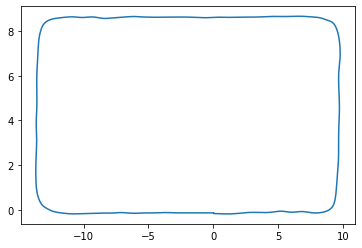

In [53]:
data = genfromtxt('data-for-mpc.csv', delimiter=',')
x_list = data[::5, 0] 
y_list = data[::5, 1]
L = len(x_list)
plt.plot(x_list, y_list)

In [54]:
car = linGP_car(np.zeros((3)), gp_dx, gp_dy, gp_dth)
ref = np.hstack([np.vstack([x_list, y_list]), [[x_list[-1]], [y_list[-1]]]*np.ones(car.H)])
# ref = np.array([np.linspace(0, 20, 201), np.linspace(0, 20, 201)])
car.set_params(np.array([1, 1]), np.array([0.01, 1]), ref)
car.formulate_linGPMPC()

In [55]:
t_hist = np.empty(L)
X_hist = np.empty((3,L+1))
X_hist[:,0] = car.st
for i in range(L):
    start = time.time()
    u = car.control(i)
    end = time.time()
    t_hist[i] = (end - start)
    car.run(u)
    X_hist[:,i+1] = car.st

0 0.001003265380859375
0 0.0
0 0.0010302066802978516
1 0.0
1 0.0
1 0.0010302066802978516
2 0.0
2 0.0010004043579101562
2 0.00096893310546875
3 0.0
3 0.0
0 0.0
0 0.0
0 0.0010008811950683594
1 0.0
1 0.0
1 0.0009992122650146484
2 0.0010013580322265625
2 0.0
2 0.0009982585906982422
3 0.0
3 0.0010001659393310547
0 0.0
0 0.0
0 0.0010175704956054688
1 0.0009634494781494141
1 0.0009899139404296875
1 0.0
2 0.0
2 0.0009703636169433594
0 0.0009679794311523438
0 0.0
0 0.002045154571533203
1 0.0009534358978271484
1 0.0
1 0.0020303726196289062
2 0.0
2 0.0
0 0.0
0 0.0
0 0.0019986629486083984
1 0.0
1 0.00099945068359375
0 0.0010039806365966797
0 0.0010297298431396484
0 0.0009989738464355469
1 0.0009791851043701172
1 0.0
0 0.0
0 0.0
0 0.000995635986328125
1 0.0
1 0.0
0 0.0
0 0.0010006427764892578
0 0.0009992122650146484
1 0.0
1 0.0
0 0.0
0 0.0
0 0.0009996891021728516
1 0.0009968280792236328
1 0.0
0 0.0
0 0.0
0 0.001001119613647461
1 0.0
1 0.0009989738464355469
0 0.0010025501251220703
0 0.0
0 0.00199723

18 0.0
18 0.0
19 0.0010006427764892578
19 0.0
0 0.0009992122650146484
0 0.0009768009185791016
0 0.0010242462158203125
1 0.0
1 0.0009992122650146484
2 0.0
2 0.0
3 0.0
3 0.0010004043579101562
4 0.0
4 0.0
5 0.0
5 0.0010006427764892578
6 0.0
6 0.0
6 0.0009996891021728516
7 0.0010004043579101562
7 0.0
8 0.0
8 0.0010058879852294922
9 0.0
9 0.0
9 0.0009722709655761719
10 0.0
10 0.0
11 0.0
11 0.0010085105895996094
11 0.0010209083557128906
12 0.0
12 0.0009999275207519531
13 0.0010006427764892578
13 0.0
13 0.001032114028930664
14 0.0
14 0.0
0 0.0
0 0.0009970664978027344
0 0.0009987354278564453
1 0.001001596450805664
1 0.0
2 0.0
2 0.0010004043579101562
3 0.0
3 0.0
4 0.0
4 0.0
5 0.0010001659393310547
5 0.0009696483612060547
6 0.0
6 0.00102996826171875
6 0.0009675025939941406
7 0.0
7 0.0010013580322265625
8 0.0
8 0.0
9 0.0
9 0.0
9 0.003004312515258789
10 0.0
10 0.0
10 0.0010037422180175781
11 0.0
11 0.0
11 0.0010013580322265625
12 0.0009989738464355469
12 0.0
12 0.0009980201721191406
13 0.001002311

33 0.0019936561584472656
34 0.0010023117065429688
34 0.0
35 0.0
35 0.0
35 0.0009992122650146484
36 0.0009701251983642578
36 0.0
0 0.0
0 0.0
0 0.0
1 0.0010116100311279297
1 0.0
1 0.0019884109497070312
2 0.0
2 0.0010004043579101562
0 0.0
0 0.00099945068359375
0 0.0009989738464355469
1 0.0010008811950683594
1 0.0
1 0.002000570297241211
2 0.0
2 0.00102996826171875
2 0.0009984970092773438
3 0.0010001659393310547
3 0.0
0 0.0009906291961669922
0 0.0
0 0.00099945068359375
1 0.001001119613647461
1 0.0
1 0.00099945068359375
2 0.0
2 0.0
3 0.0
3 0.0
4 0.0
4 0.0
5 0.0009999275207519531
5 0.0
5 0.0009660720825195312
6 0.0
6 0.0010311603546142578
7 0.0
7 0.0
7 0.001020193099975586
8 0.0
8 0.0
8 0.0009951591491699219
9 0.0
9 0.0009989738464355469
9 0.0010027885437011719
10 0.0
10 0.0
10 0.0009975433349609375
11 0.0009999275207519531
11 0.0
12 0.0
12 0.0
12 0.0009677410125732422
13 0.0
13 0.0
13 0.0010013580322265625
14 0.0
14 0.0
14 0.0010013580322265625
15 0.0
15 0.0009672641754150391
15 0.0019989013

7 0.0
7 0.0
8 0.0
8 0.0
9 0.0
9 0.0
9 0.0019996166229248047
10 0.0
10 0.001001119613647461
11 0.0
11 0.0
12 0.0
12 0.0
12 0.0019690990447998047
13 0.0
13 0.0010037422180175781
0 0.0
0 0.0009992122650146484
0 0.0010004043579101562
1 0.0
1 0.0
2 0.0
2 0.0
3 0.0009920597076416016
3 0.0
4 0.0009989738464355469
4 0.0
5 0.0009982585906982422
5 0.0
6 0.0
6 0.0009992122650146484
7 0.0
7 0.0010030269622802734
7 0.0019965171813964844
8 0.0010006427764892578
8 0.0
9 0.0010025501251220703
9 0.0
9 0.0019965171813964844
10 0.0010344982147216797
10 0.0
0 0.0
0 0.0009992122650146484
0 0.0019996166229248047
1 0.0
1 0.0010323524475097656
2 0.0
2 0.0
3 0.0
3 0.0
4 0.0010142326354980469
4 0.0
5 0.0
5 0.0009677410125732422
6 0.0
6 0.0009999275207519531
6 0.0009992122650146484
7 0.0
7 0.0010156631469726562
7 0.0009672641754150391
8 0.0
8 0.0010061264038085938
8 0.0009644031524658203
9 0.0
9 0.0
10 0.0
10 0.0009996891021728516
11 0.0
11 0.00102996826171875
11 0.0019714832305908203
12 0.0
12 0.001031875610351

12 0.0009984970092773438
13 0.0009691715240478516
13 0.0
14 0.0010352134704589844
14 0.0
15 0.0
15 0.0009679794311523438
16 0.0
16 0.0010313987731933594
17 0.0
17 0.0
18 0.0009968280792236328
18 0.0
18 0.004000186920166016
19 0.0
19 0.0010001659393310547
19 0.0010044574737548828
20 0.0
20 0.0009682178497314453
20 0.001001119613647461
21 0.0
21 0.0
21 0.001028299331665039
22 0.0
22 0.0
23 0.0009982585906982422
23 0.0
24 0.0
24 0.0
25 0.0
25 0.0009975433349609375
25 0.0009672641754150391
26 0.0009703636169433594
26 0.0009984970092773438
26 0.0010318756103515625
27 0.0010035037994384766
27 0.0009667873382568359
28 0.0
28 0.001028299331665039
29 0.0
29 0.0
30 0.0
30 0.0
30 0.002033233642578125
31 0.0
31 0.0
31 0.0010275840759277344
32 0.0
32 0.0009996891021728516
0 0.0
0 0.0010287761688232422
0 0.0009999275207519531
1 0.0009996891021728516
1 0.0
1 0.0009999275207519531
2 0.0
2 0.0
2 0.001005411148071289
3 0.0
3 0.0009953975677490234
0 0.0010001659393310547
0 0.0009698867797851562
0 0.00103

0 0.00102996826171875
0 0.0
0 0.0010085105895996094
1 0.0
1 0.0
1 0.0010390281677246094
2 0.0
2 0.0
0 0.0
0 0.0
0 0.0009989738464355469
1 0.0
1 0.0
0 0.0
0 0.0
0 0.0019795894622802734
1 0.0
1 0.0
0 0.0009996891021728516
0 0.0
0 0.0010023117065429688
1 0.0009670257568359375
1 0.0
0 0.0
0 0.0
0 0.0010013580322265625
1 0.0
1 0.0
0 0.0010006427764892578
0 0.0
0 0.001001596450805664
1 0.0009984970092773438
1 0.0
0 0.0009703636169433594
0 0.0
0 0.0020291805267333984
1 0.0
1 0.0
0 0.0
0 0.0010030269622802734
0 0.0009975433349609375
1 0.0
1 0.0009706020355224609
0 0.0
0 0.0
0 0.0009999275207519531
1 0.0
1 0.0
1 0.001004934310913086
2 0.0
2 0.0
0 0.0
0 0.0
0 0.0009992122650146484
1 0.0
1 0.0009989738464355469
1 0.0010006427764892578
2 0.0
2 0.0009701251983642578
0 0.0010023117065429688
0 0.0
0 0.00099945068359375
1 0.0
1 0.0
1 0.0009989738464355469
2 0.0
2 0.0010004043579101562
0 0.0
0 0.0
0 0.0009636878967285156
1 0.0010328292846679688
1 0.0
0 0.0
0 0.0009703636169433594
0 0.001029491424560546

0 0.0019922256469726562
1 0.0010013580322265625
1 0.0
2 0.0009703636169433594
2 0.0
3 0.0
3 0.00099945068359375
4 0.0010025501251220703
4 0.0
5 0.0
5 0.0010001659393310547
5 0.0009992122650146484
6 0.0
6 0.0
7 0.0
7 0.0010006427764892578
8 0.0
8 0.0
8 0.0020020008087158203
9 0.0
9 0.0
10 0.0
10 0.0
11 0.0009980201721191406
11 0.0
11 0.0019676685333251953
12 0.0010271072387695312
12 0.0
12 0.00099945068359375
13 0.0
13 0.0
13 0.0020301342010498047
14 0.0
14 0.0010013580322265625
14 0.0009670257568359375
15 0.0
15 0.0009987354278564453
16 0.0
16 0.0
16 0.0009992122650146484
17 0.0
17 0.0
17 0.0010006427764892578
18 0.0
18 0.0009968280792236328
18 0.0010018348693847656
19 0.0
19 0.0
19 0.0020303726196289062
20 0.0
20 0.0
20 0.0
21 0.0
21 0.0
22 0.0
22 0.0010097026824951172
23 0.0
23 0.0009949207305908203
23 0.0009903907775878906
24 0.0010051727294921875
24 0.0
24 0.0010004043579101562
25 0.0010025501251220703
25 0.0
25 0.0009682178497314453
26 0.0
26 0.0
26 0.000997781753540039
27 0.0
27 

0 0.0009984970092773438
1 0.0
1 0.0
0 0.0009911060333251953
0 0.0
0 0.0019762516021728516
1 0.0
1 0.0
0 0.0
0 0.0010018348693847656
0 0.0009996891021728516
1 0.0010001659393310547
1 0.0
0 0.0
0 0.0010483264923095703
0 0.0009834766387939453
1 0.0
1 0.0010294914245605469
0 0.0009982585906982422
0 0.0
0 0.0010004043579101562
1 0.0
1 0.0
0 0.0
0 0.0
0 0.0009984970092773438
1 0.0010013580322265625
1 0.0
0 0.0
0 0.0
0 0.0009996891021728516
1 0.0
1 0.0009982585906982422
0 0.0
0 0.0
0 0.0009987354278564453
1 0.0
1 0.0
0 0.0009958744049072266
0 0.0
0 0.0009965896606445312
1 0.0
1 0.0009992122650146484
0 0.0010051727294921875
0 0.0
0 0.0009958744049072266
1 0.0
1 0.0
0 0.0
0 0.0
0 0.0010302066802978516
1 0.0
1 0.0010006427764892578
0 0.0010039806365966797
0 0.0
0 0.0010006427764892578
1 0.0
1 0.0
0 0.0
0 0.0009963512420654297
0 0.0009672641754150391
1 0.0
1 0.0
1 0.0010004043579101562
2 0.00099945068359375
2 0.0
0 0.0
0 0.0009999275207519531
0 0.0010001659393310547
1 0.0
1 0.0
1 0.00086784362792

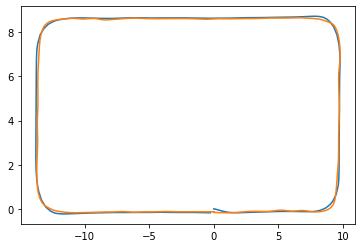

In [56]:
plt.plot(X_hist[0,:], X_hist[1,])
plt.plot(car.ref[0,0:L], car.ref[1,0:L])

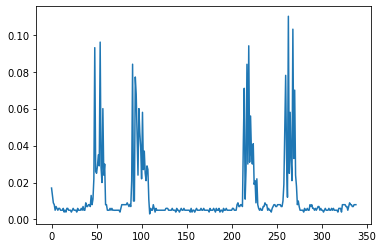

In [50]:
plt.plot(t_hist)

In [51]:
np.mean(t_hist)

0.01242208480834961

In [26]:
start = time.time()
predict(gp_dx.X[0,:], gp_dx.alpha, gp_dx.beta, gp_dx.rbf_variance, gp_dx.lambda_inv, gp_dx.noise_variance, gp_dx.Z, gp_dx.N_ind)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

start = time.time()
for i in range(1000):
    predict(gp_dx.X[0,:], gp_dx.alpha, gp_dx.beta, gp_dx.rbf_variance, gp_dx.lambda_inv, gp_dx.noise_variance, gp_dx.Z, gp_dx.N_ind)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.0
Elapsed (after compilation) = 0.009996891021728516


In [27]:
start = time.time()
linearize(gp_dx.X[0,:], gp_dx.alpha, gp_dx.beta, gp_dx.rbf_variance, gp_dx.lambda_inv, gp_dx.noise_variance, gp_dx.Z, gp_dx.N_ind, gp_dx.n)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

start = time.time()
for i in range(1000):
    linearize(gp_dx.X[0,:], gp_dx.alpha, gp_dx.beta, gp_dx.rbf_variance, gp_dx.lambda_inv, gp_dx.noise_variance, gp_dx.Z, gp_dx.N_ind, gp_dx.n)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.0
Elapsed (after compilation) = 0.020000219345092773
